In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import os
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

import warnings
warnings.filterwarnings('ignore')

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
cd 'drive/My Drive/231205 AI와 기후변화 실습/유입량 예측'

[Errno 2] No such file or directory: 'drive/My Drive/231205 AI와 기후변화 실습/유입량 예측'
/content/drive/My Drive/231205 AI와 기후변화 실습/유입량 예측


In [34]:
ym =pd.read_csv('./연월일.csv', )
ym['YR'] = pd.to_datetime(ym['YR'])

In [35]:
rawdata = pd.read_csv('./HC_2022.csv')
rawdata.index = pd.to_datetime(rawdata['날짜'])
rawdata = rawdata.drop(columns=['날짜'])
rawdata.columns = ['Temp', 'Precip', 'Inflow']
rawdata['Precip'] = rawdata['Precip'].fillna(method='ffill')

rawdata['Precip_1'] = rawdata['Precip'].shift(1)
# rawdata['Precip_2'] = rawdata['Precip'].shift(2)
# rawdata['Precip_3'] = rawdata['Precip'].shift(3)
# rawdata['Precip_4'] = rawdata['Precip'].shift(4)
# rawdata['Precip_5'] = rawdata['Precip'].shift(5)

rawdata = rawdata.dropna()
rawdata

Temp  Precip  Inflow  Precip_1
날짜                                        
1989-02-01   2.8   119.0    8.06     120.5
1989-03-01   6.4   108.0   20.31     119.0
1989-04-01  13.5    51.4    6.90     108.0
1989-05-01  18.2    36.0    1.73      51.4
1989-06-01  20.5   214.5   23.35      36.0
...          ...     ...     ...       ...
2023-06-01  23.2   196.3   27.38     221.4
2023-07-01  25.8   422.9  135.58     196.3
2023-08-01  27.0   503.0   74.64     422.9
2023-09-01  23.1   160.3   40.72     503.0
2023-10-01  15.1     6.3    8.77     160.3

[417 rows x 4 columns]

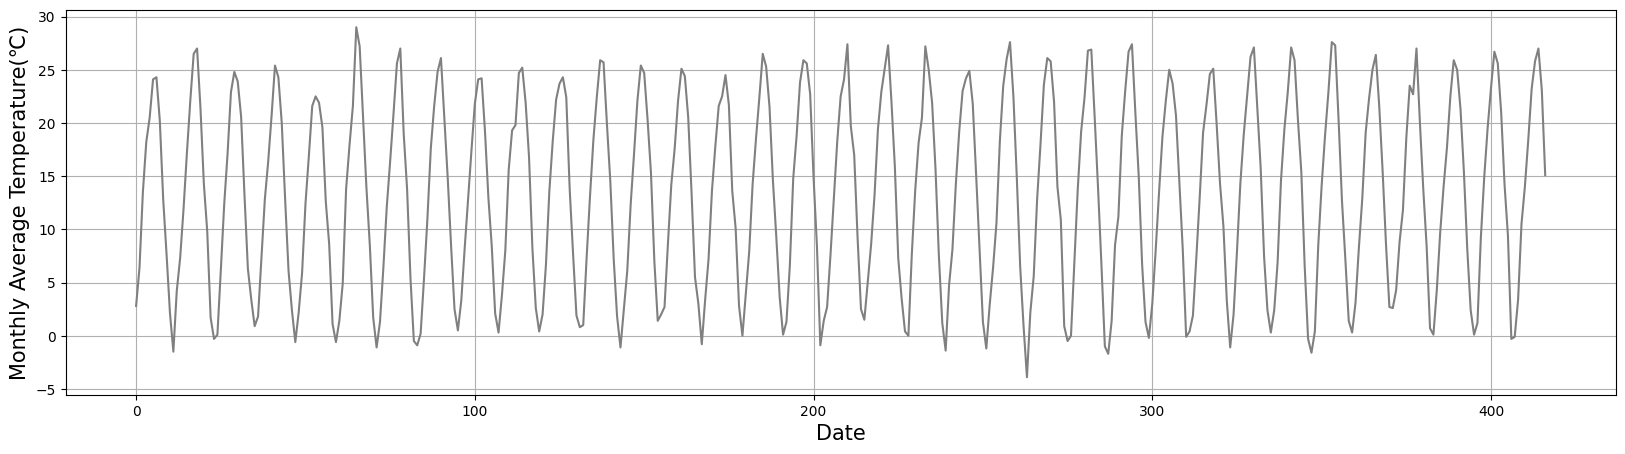

In [36]:
plt.figure(figsize=(20, 5))
plt.plot(np.array(rawdata['Temp']), c='gray')
plt.grid()
plt.ylabel('Monthly Average Temperature(℃)', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.show()

In [37]:
rawdata['Temp'].describe()

count    417.000000
mean      13.353477
std        9.039619
min       -3.900000
25%        5.400000
50%       13.900000
75%       21.700000
max       29.000000
Name: Temp, dtype: float64

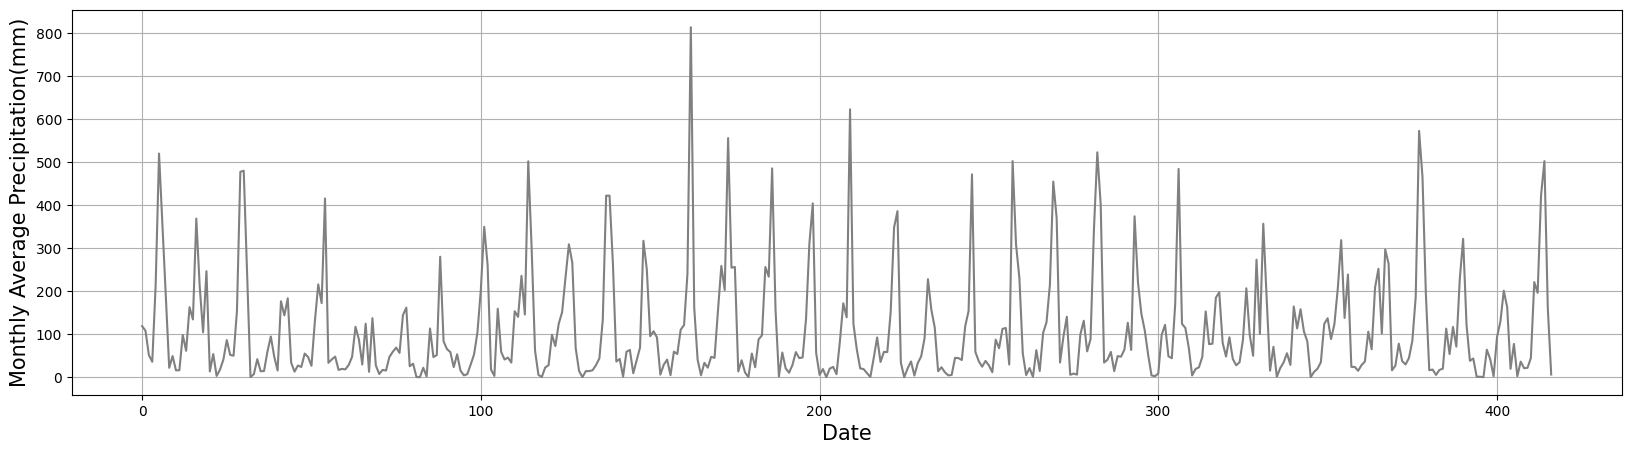

In [38]:
plt.figure(figsize=(20, 5))
plt.plot(np.array(rawdata['Precip']), c='gray')
plt.grid()
plt.ylabel('Monthly Average Precipitation(mm)', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.show()

In [39]:
rawdata['Precip'].describe()

count    417.000000
mean     108.975540
std      126.399393
min        0.000000
25%       23.900000
50%       58.500000
75%      144.500000
max      814.500000
Name: Precip, dtype: float64

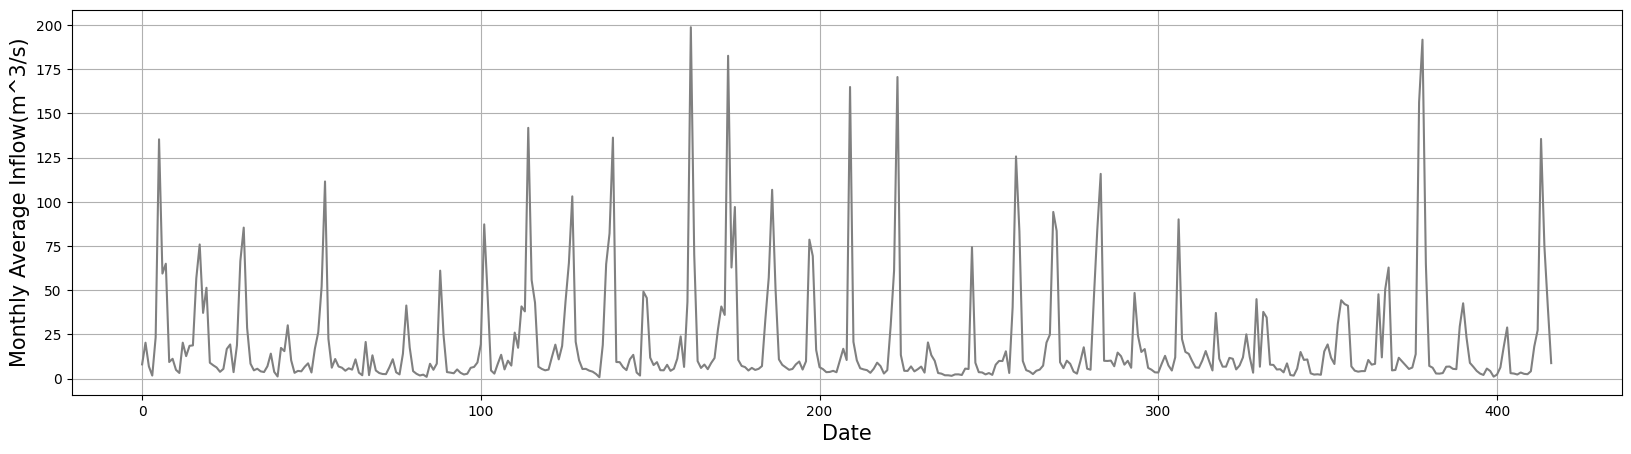

In [40]:
plt.figure(figsize=(20, 5))
plt.plot(np.array(rawdata['Inflow']), c='gray')
plt.grid()
plt.ylabel('Monthly Average Inflow(m^3/s)', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.show()

In [41]:
rawdata['Inflow'].describe()

count    417.000000
mean      20.291942
std       31.204396
min        0.790000
25%        4.660000
50%        8.060000
75%       18.880000
max      198.770000
Name: Inflow, dtype: float64

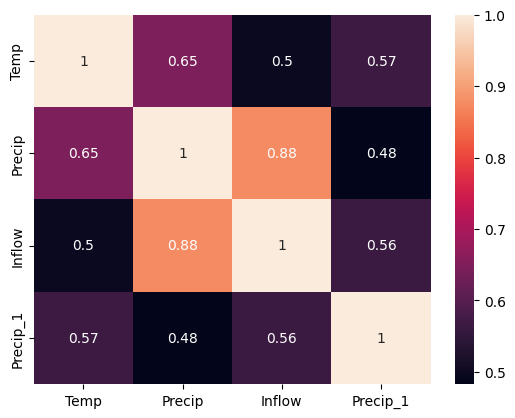

In [42]:
sns.heatmap(rawdata.corr(), annot=True)
plt.show()

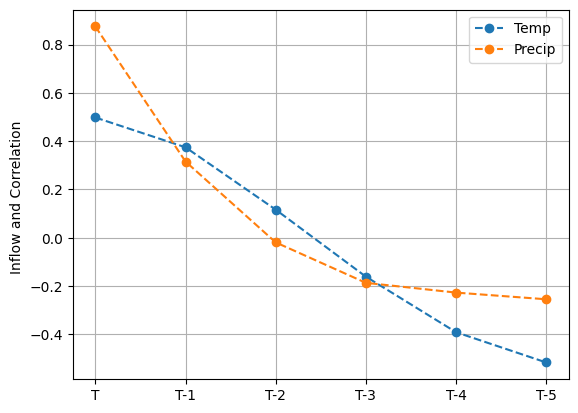

In [43]:
import statsmodels.api

plt.plot(['T', 'T-1', 'T-2', 'T-3', 'T-4', 'T-5'], statsmodels.api.tsa.ccf(x=rawdata['Temp'], y=rawdata['Inflow'])[:6], 'o--', label='Temp')
plt.plot(['T', 'T-1', 'T-2', 'T-3', 'T-4', 'T-5'], statsmodels.api.tsa.ccf(x=rawdata['Precip'], y=rawdata['Inflow'])[:6], 'o--', label='Precip')

plt.legend()
plt.grid()
plt.ylabel('Inflow and Correlation ')
plt.show()

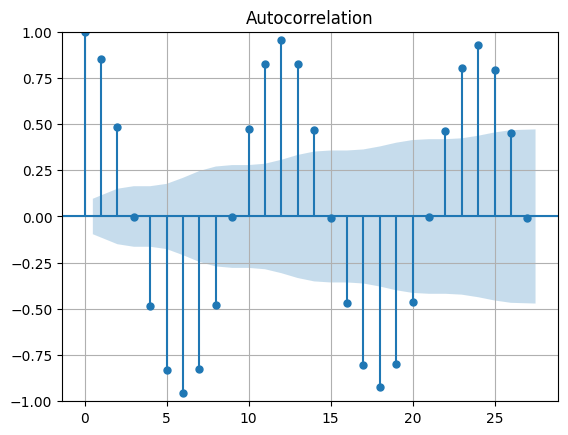

In [44]:
import statsmodels.graphics.tsaplots as sm

sm.plot_acf(rawdata['Temp'])
plt.grid()
plt.show()

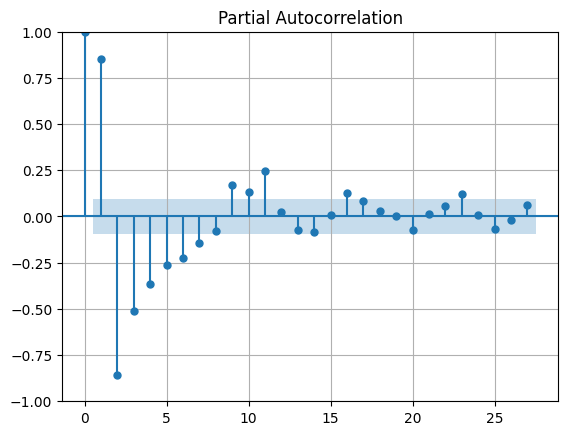

In [45]:
sm.plot_pacf(rawdata['Temp'])
plt.grid()
plt.show()

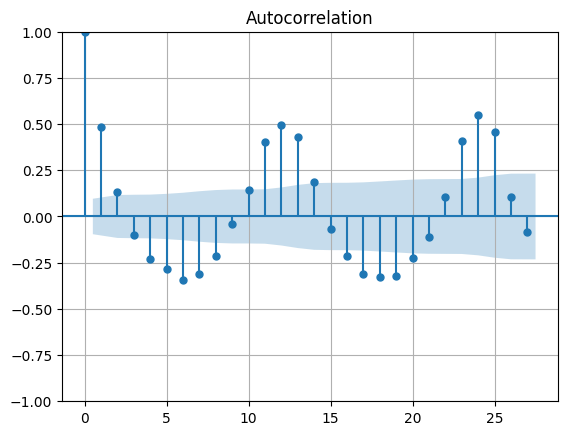

In [46]:
sm.plot_acf(rawdata['Precip'])
plt.grid()
plt.show()

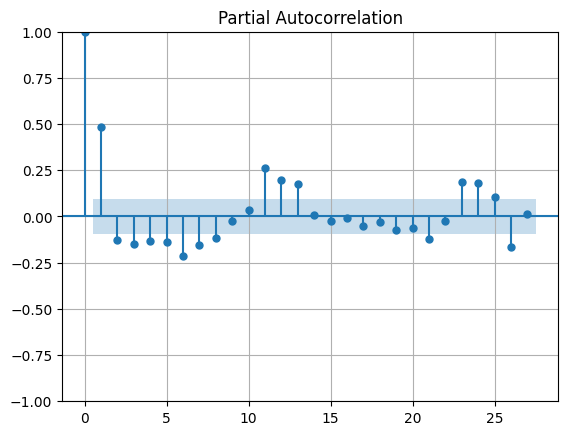

In [47]:
sm.plot_pacf(rawdata['Precip'])
plt.grid()
plt.show()

# 1. Temp, Precip 만 사용 (MLP)

In [49]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

X = rawdata.drop(columns=['Inflow', 'Precip_1'])
y = rawdata[['Inflow']].copy()

test_date = '2021-01-01'
x_train = X.loc[X.index < test_date, :]
x_test = X.loc[X.index >= test_date, :]

y_train = y.loc[y.index < test_date, :]
y_test = y.loc[y.index >= test_date, :]

# 스케일링 적용
scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

scaler.fit(x_train)
y_scaler.fit(y_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [51]:
keras.backend.clear_session()
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(x_train.shape[1],)))
model.add(keras.layers.Dense(units=30, activation='sigmoid'))
model.add(keras.layers.Dense(units=15, activation='sigmoid'))
model.add(keras.layers.Dense(units=1, activation='relu'))

model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001))
model.fit(x_train_scaled, y_train_scaled, batch_size=12, epochs=100, verbose=1)

Epoch 1/100
32/32 [==============================] - 2s 7ms/step - loss: 0.3289
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0337
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0269
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0262
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0258
Epoch 6/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0254
Epoch 7/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0252
Epoch 8/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0247
Epoch 9/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0243
Epoch 10/100
32/32 [==============================] - 0s 4ms/step - loss: 0.0241
Epoch 11/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0235
Epoch 12/100
32/32 [==============================] - 0s 4ms/step - loss: 0.0231
Epoch 13/100
32/32 [=================

In [52]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred_te = model.predict(x_test_scaled)
y_pred_tr = model.predict(x_train_scaled)

print('MSE : ', mean_squared_error(y_scaler.inverse_transform(y_train_scaled), y_scaler.inverse_transform(np.array([0 if x < 0.0 else x for x in y_pred_tr]).reshape(-1, 1))))
print('MAE : ', mean_absolute_error(y_scaler.inverse_transform(y_train_scaled), y_scaler.inverse_transform(np.array([0 if x < 0.0 else x for x in y_pred_tr]).reshape(-1, 1))))
print('R2 : ', r2_score(y_scaler.inverse_transform(y_train_scaled), y_scaler.inverse_transform(np.array([0 if x < 0.0 else x for x in y_pred_tr]).reshape(-1, 1))))
print('-'*50)

print('MSE : ', mean_squared_error(y_scaler.inverse_transform(y_test_scaled), y_scaler.inverse_transform(np.array([0 if x < 0.0 else x for x in y_pred_te]).reshape(-1, 1))))
print('MAE : ', mean_absolute_error(y_scaler.inverse_transform(y_test_scaled), y_scaler.inverse_transform(np.array([0 if x < 0.0 else x for x in y_pred_te]).reshape(-1, 1))))
print('R2 : ', r2_score(y_scaler.inverse_transform(y_test_scaled), y_scaler.inverse_transform(np.array([0 if x < 0.0 else x for x in y_pred_te]).reshape(-1, 1))))

12/12 [==============================] - 0s 2ms/step
MSE :  230.7801165891162
MAE :  9.66203489794121
R2 :  0.7682709938710732
--------------------------------------------------
MSE :  213.1288788316916
MAE :  9.65504194512087
R2 :  0.6842379603778346


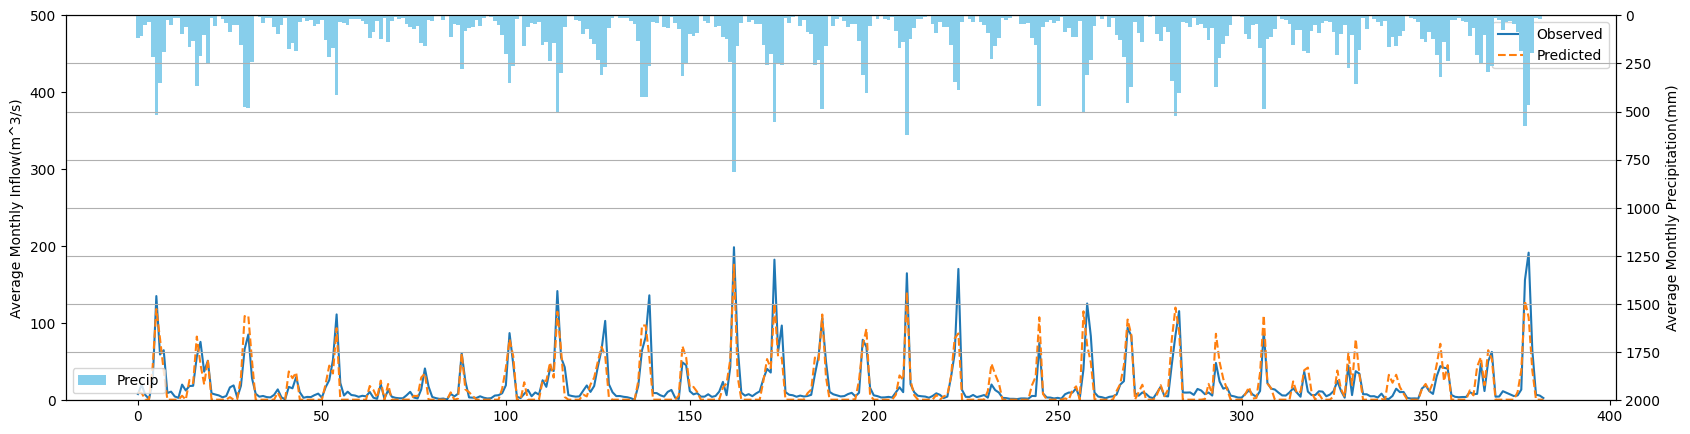

In [55]:
fig, ax1 = plt.subplots(figsize=(20, 5))

ax1.plot(np.array(y_train), label='Observed')
ax1.plot(y_scaler.inverse_transform(np.array([0 if x < 0.0 else x for x in  y_pred_tr]).reshape(-1, 1)), '--', label='Predicted')
ax1.set_ylim(0, 500)
plt.ylabel('Average Monthly Inflow(m^3/s)')
plt.xticks(rotation=0)
plt.legend()

ax2 = ax1.twinx()
ax2.bar(x=range(len(x_train['Precip'])), height=x_train['Precip'], width=1, color='skyblue', label='Precip')
ax2.set_ylim(0, 2000)
plt.ylabel('Average Monthly Precipitation(mm)')
plt.gca().invert_yaxis()
plt.legend()
plt.grid()
plt.show()

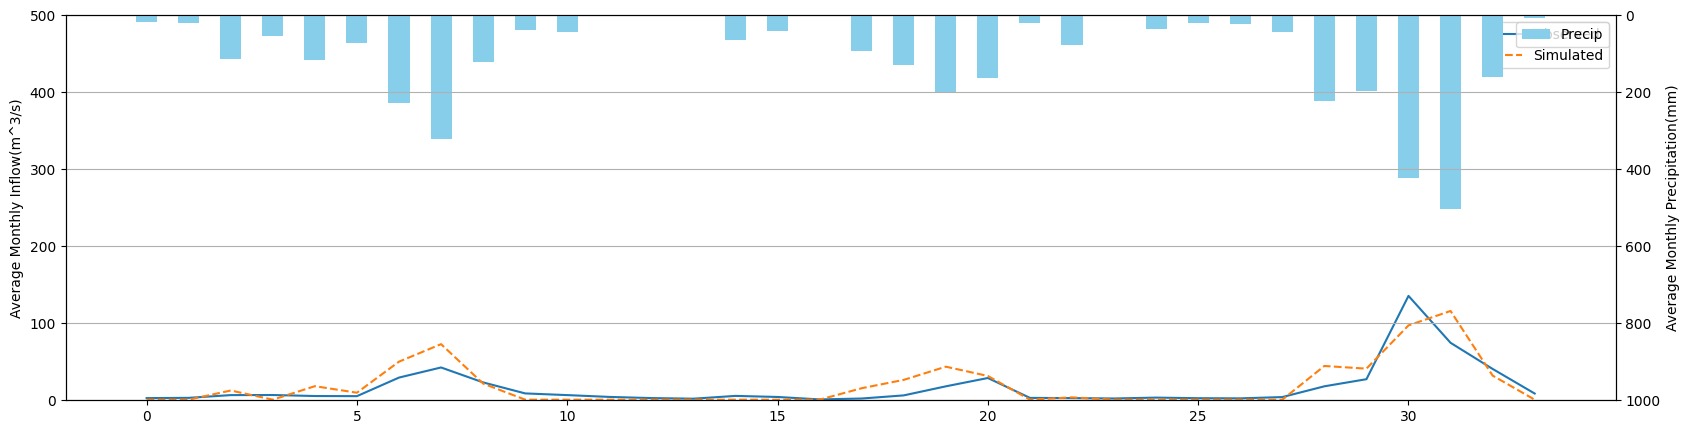

In [56]:
fig, ax1 = plt.subplots(figsize=(20, 5))

ax1.plot(np.array(y_test), label='Observed')
ax1.plot(y_scaler.inverse_transform(np.array([0 if x < 0.0 else x for x in  y_pred_te]).reshape(-1, 1)), '--', label='Simulated')
ax1.set_ylim(0, 500)
plt.ylabel('Average Monthly Inflow(m^3/s)')
plt.xticks(rotation=0)
plt.legend()

ax2 = ax1.twinx()
ax2.bar(x=range(len(x_test['Precip'])), height=x_test['Precip'], width=0.5, color='skyblue', label='Precip')
ax2.set_ylim(0, 1000)
plt.ylabel('Average Monthly Precipitation(mm)')
plt.gca().invert_yaxis()
plt.legend()
plt.grid()
plt.show()

In [ ]:
# y_pred_tr_temp = np.array([0 if x < 0.0 else x for x in  y_pred_tr])
# y_pred_tr_temp = y_scaler.inverse_transform(y_pred_tr_temp.reshape(-1, 1))
# y_pred_tr_scale = y_pred_tr_temp

# result_tr_MLP = np.concatenate([y_train.values, y_pred_tr_scale], axis=1)
# result_tr_MLP = pd.DataFrame(result_tr_MLP)
# result_tr_MLP.columns = ['Observed', 'Predicted']
# result_tr_MLP.index = y_train.index
# result_tr_MLP.to_csv('./result_tr_MLP_2_HC.csv', encoding='utf-8-sig')

# y_pred_te_temp = np.array([0 if x < 0.0 else x for x in  y_pred_te])
# y_pred_te_temp = y_scaler.inverse_transform(y_pred_te_temp.reshape(-1, 1))
# y_pred_te_scale = y_pred_te_temp

# result_te_MLP = np.concatenate([y_test.values, y_pred_te_scale], axis=1)
# result_te_MLP = pd.DataFrame(result_te_MLP)
# result_te_MLP.columns = ['Observed', 'Predicted']
# result_te_MLP.index = y_test.index
# result_te_MLP.to_csv('./result_te_MLP_2_HC.csv', encoding='utf-8-sig')

# 2. Temp, Precip Lag=1 적용 (MLP)

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

X = rawdata.drop(columns=['Inflow'])
y = rawdata[['Inflow']].copy()

test_date = '2021-01-01'
x_train = X.loc[X.index < test_date, :]
x_test = X.loc[X.index >= test_date, :]

y_train = y.loc[y.index < test_date, :]
y_test = y.loc[y.index >= test_date, :]

# 스케일링 적용
scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

scaler.fit(x_train)
y_scaler.fit(y_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

NameError: ignored

In [2]:
keras.backend.clear_session()
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(x_train.shape[1],)))
model.add(keras.layers.Dense(units=30, activation='sigmoid'))
model.add(keras.layers.Dense(units=15, activation='sigmoid'))
model.add(keras.layers.Dense(units=1, activation='relu'))

model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001))
model.fit(x_train_scaled, y_train_scaled, batch_size=12, epochs=100, verbose=1)

NameError: ignored

In [67]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred_te = model.predict(x_test_scaled)
y_pred_tr = model.predict(x_train_scaled)

print('MSE : ', mean_squared_error(y_scaler.inverse_transform(y_train_scaled), y_scaler.inverse_transform(np.array([0 if x < 0.0 else x for x in y_pred_tr]).reshape(-1, 1))))
print('MAE : ', mean_absolute_error(y_scaler.inverse_transform(y_train_scaled), y_scaler.inverse_transform(np.array([0 if x < 0.0 else x for x in y_pred_tr]).reshape(-1, 1))))
print('R2 : ', r2_score(y_scaler.inverse_transform(y_train_scaled), y_scaler.inverse_transform(np.array([0 if x < 0.0 else x for x in y_pred_tr]).reshape(-1, 1))))
print('-'*50)

print('MSE : ', mean_squared_error(y_scaler.inverse_transform(y_test_scaled), y_scaler.inverse_transform(np.array([0 if x < 0.0 else x for x in y_pred_te]).reshape(-1, 1))))
print('MAE : ', mean_absolute_error(y_scaler.inverse_transform(y_test_scaled), y_scaler.inverse_transform(np.array([0 if x < 0.0 else x for x in y_pred_te]).reshape(-1, 1))))
print('R2 : ', r2_score(y_scaler.inverse_transform(y_test_scaled), y_scaler.inverse_transform(np.array([0 if x < 0.0 else x for x in y_pred_te]).reshape(-1, 1))))

12/12 [==============================] - 0s 2ms/step
MSE :  181.62462561911607
MAE :  8.73237676996475
R2 :  0.817628595542355
--------------------------------------------------
MSE :  211.77500341747327
MAE :  8.811532501683516
R2 :  0.6862438005273784


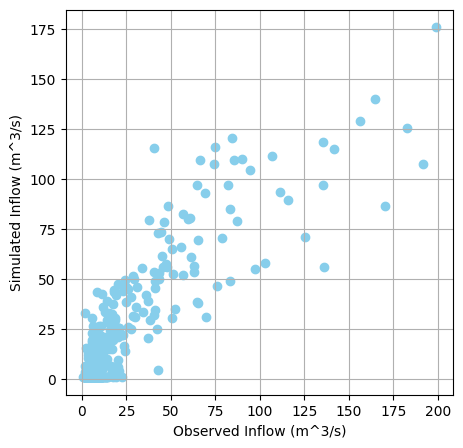

In [60]:
plt.figure(figsize=(5, 5))
plt.scatter(x=y, y=y_scaler.inverse_transform(np.array([0 if x < 0.0 else x for x in  np.concatenate([y_pred_tr, y_pred_te])]).reshape(-1, 1)), color='skyblue')

plt.xlabel('Observed Inflow (m^3/s)')
plt.ylabel('Simulated Inflow (m^3/s)')
plt.grid()
plt.show()

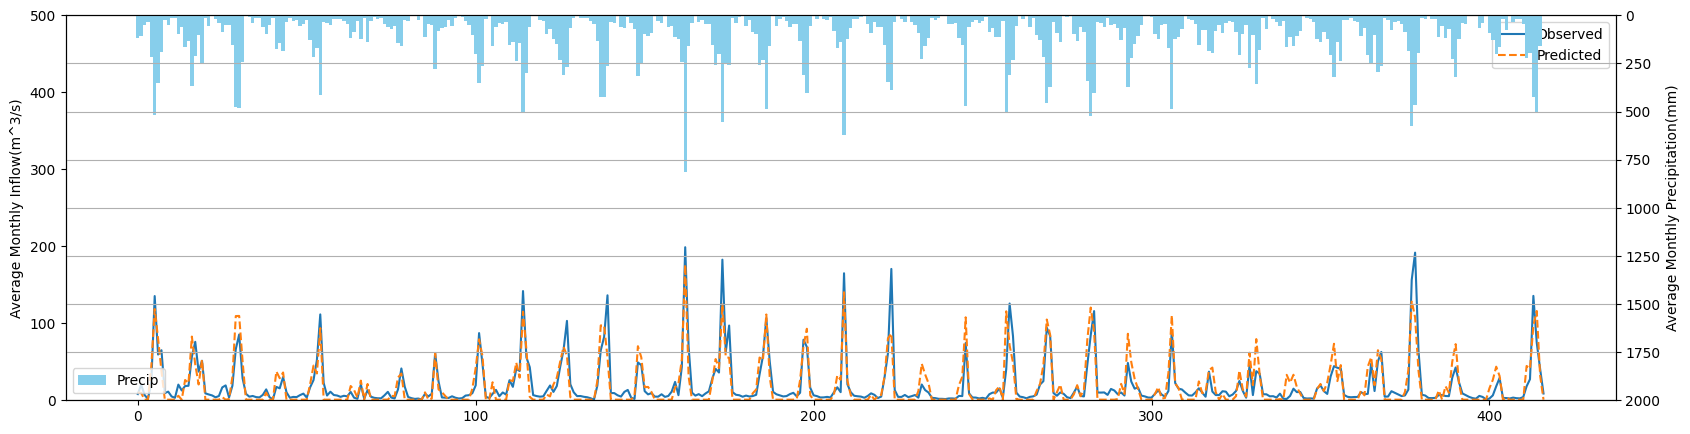

In [62]:
fig, ax1 = plt.subplots(figsize=(20, 5))

ax1.plot(np.array(y), label='Observed')
plt.plot(y_scaler.inverse_transform(np.array([0 if x < 0.0 else x for x in  np.concatenate([y_pred_tr, y_pred_te])]).reshape(-1, 1)), '--', label='Predicted')
ax1.set_ylim(0, 500)
plt.ylabel('Average Monthly Inflow(m^3/s)')
plt.xticks(rotation=0)
plt.legend()

ax2 = ax1.twinx()
ax2.bar(x=range(len(X['Precip'])), height=X['Precip'], width=1, color='skyblue', label='Precip')
ax2.set_ylim(0, 2000)
plt.ylabel('Average Monthly Precipitation(mm)')
plt.gca().invert_yaxis()
plt.legend()
plt.grid()
plt.show()

In [64]:
temp = y.copy()
temp['Predicted'] = y_scaler.inverse_transform(np.array([0 if x < 0.0 else x for x in  np.concatenate([y_pred_tr, y_pred_te])]).reshape(-1, 1))
temp.columns = ['Observed', 'Predicted']

In [65]:
temp['Month'] = [ str(x)[5:7] for x in temp.index]

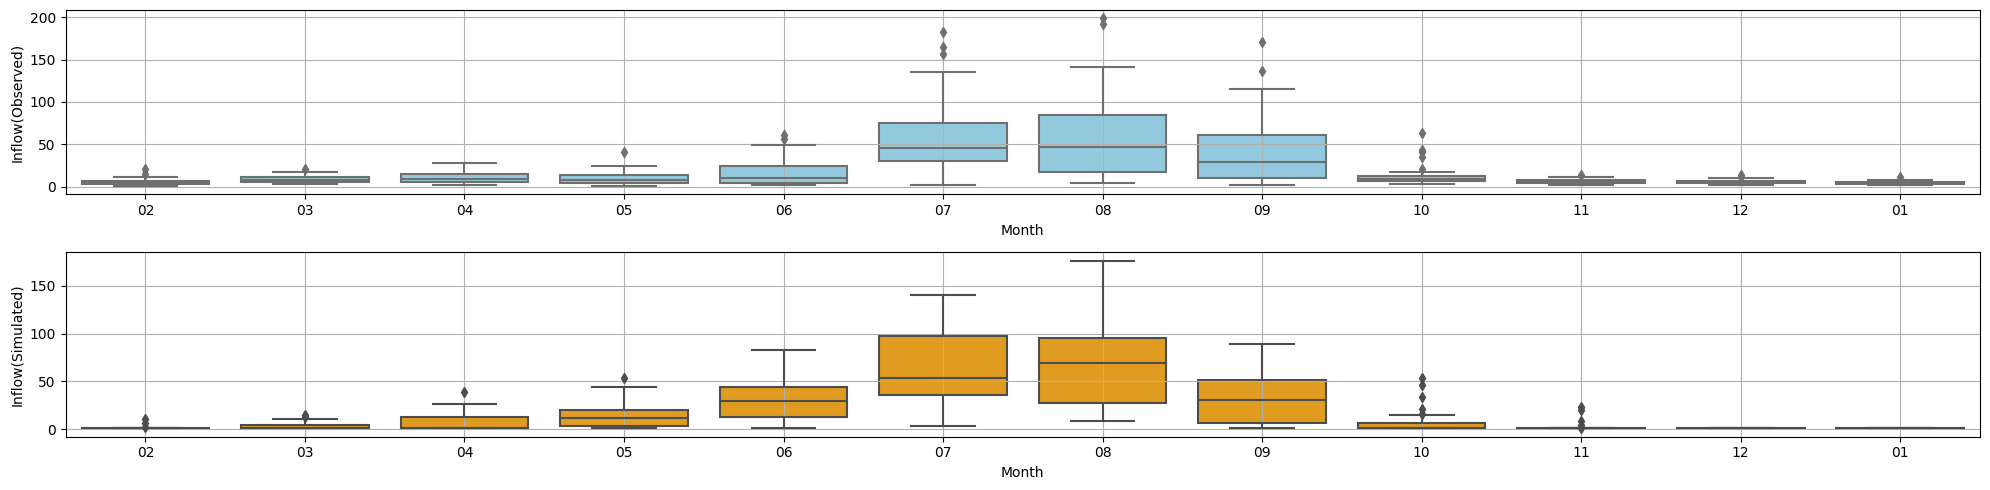

In [66]:
plt.figure(figsize=(20, 5))

plt.subplot(2,1,1)
sns.boxplot(x='Month', y='Observed', data=temp, color='skyblue')
plt.grid()
plt.xticks(rotation=0)
plt.ylabel('Inflow(Observed)')

plt.subplot(2,1,2)
sns.boxplot(x='Month', y='Predicted', data=temp, color='orange')
plt.grid()
plt.xticks(rotation=0)
plt.ylabel('Inflow(Simulated)')

plt.tight_layout()
plt.show()

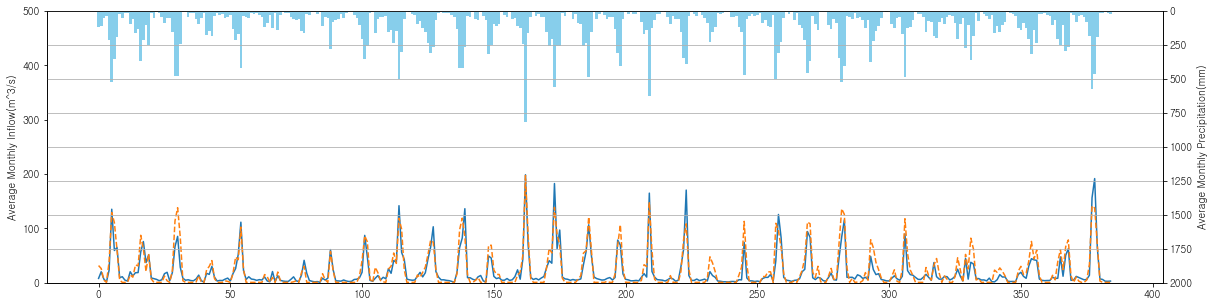

In [ ]:
fig, ax1 = plt.subplots(figsize=(20, 5))

ax1.plot(np.array(y_train), label='Observed')
ax1.plot(y_scaler.inverse_transform(np.array([0 if x < 0.0 else x for x in  y_pred_tr]).reshape(-1, 1)), '--', label='Predicted')
ax1.set_ylim(0, 500)
plt.ylabel('Average Monthly Inflow(m^3/s)')
plt.xticks(rotation=0)
# plt.legend()

ax2 = ax1.twinx()
ax2.bar(x=range(len(x_train['Precip'])), height=x_train['Precip'], width=1, color='skyblue', label='Precip')
ax2.set_ylim(0, 2000)
plt.ylabel('Average Monthly Precipitation(mm)')
plt.gca().invert_yaxis()
plt.grid()
plt.show()

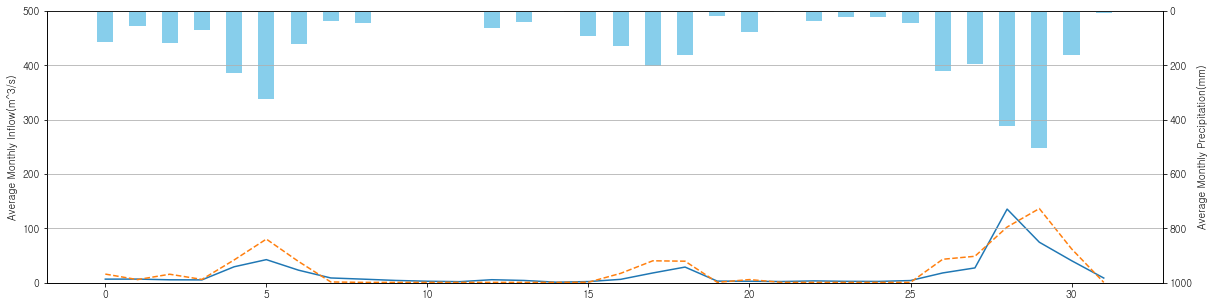

In [ ]:
fig, ax1 = plt.subplots(figsize=(20, 5))

ax1.plot(np.array(y_test), label='Observed')
ax1.plot(y_scaler.inverse_transform(np.array([0 if x < 0.0 else x for x in  y_pred_te]).reshape(-1, 1)), '--', label='Simulated')
ax1.set_ylim(0, 500)
plt.ylabel('Average Monthly Inflow(m^3/s)')
plt.xticks(rotation=0)
# plt.legend()

ax2 = ax1.twinx()
ax2.bar(x=range(len(x_test['Precip'])), height=x_test['Precip'], width=0.5, color='skyblue', label='Precip')
ax2.set_ylim(0, 1000)
plt.ylabel('Average Monthly Precipitation(mm)')
plt.gca().invert_yaxis()

plt.grid()
plt.show()